# Design of horizontal wind turbine blade 
The goal of this notebook is to solve the problem of optimal blade design of an horizontal axial wind turbine (HAWT) for electrical power generation. 

In the first part, a bidimensional NACA profile is chosen, plotted and its performance coefficients tested, by calling the external program "XFOIL". 
Aerodynamic coefficients $ {C_L} $ and $ {C_D} $ are computed for a range of increasing attack angle $ {\alpha}$. A suitable attack angle is chosen, taking into account the glide ratio $\frac {C_L}{C_D}$ trend. 

In the second part, the blade is divided in a discrete number of finite blade elements and blade element momentum equations (BEM) are applied. The solution of BEM equations for each blade element is obtained by solving a coinstrained, bounded, mono-objective maximization problem. 
The optimization problem consists in maximizing the tangential force for the given blade element, while satisfying BEM equations, expressed as functions of the axial induction factor (a), the tangential induction factor (a'), the torsion angle (${\phi}$) and the chord length (c).

In the final sections of this study, a basic 3D plot of the optimal blade shape is showed, together with the convergency analysis plot, which highlights that the found solution for the rated blade power does not depend from the blade discretization.

## Libraries
Following packages are necessary to carry out the blade design computations. Note that "scipy" has been used to solve the maximization problem, but similar libraries could be used as well. I used "SLSQP" algorithm implementation offered by scipy's "minimize" function, since this allows to solve a user-defined optimization problem with bounded design variables and to provide equality constraints in an easy way.

"Subprocess" package is necessary to run "XFOIL" program, since it's an external executable file hosted in the "xfoil_runner" subfolder.

"Airfoil" is a simple, useful package that allows to get normalized coordinates of a specified NACA profile. I used it to visualize the profile shape in the profile selection phase, and at the end of the notebook, to print out a 3D view of the whole blade.

In [1]:
import numpy as np
import pandas as pd
from math import sin, cos, acos, atan, degrees, radians, sqrt, exp
from scipy.constants import pi
from scipy.optimize import minimize, Bounds

from matplotlib import pyplot as plt
import seaborn as sns
import os
import subprocess
from airfoils import Airfoil

## Problem data
Following data can be used as inputs for the blade design problem. 
- wind upstream velocity $ {v_1} [m/s]$
- nominal shaft rotational speed: $ {\omega} [rad/s]$
    the shaft rotational speed depends from the generator charachteristic (number of polar couples, grid frequency) and the coupling (e.g. speed multiplier)
- nominal blade mechanical power: ${P} [W] $
- blade speed parameter: ${\lambda} = \frac{\omega R}{v_1} $
    According to the theory of horizontal wind turbines, for a 3 bladed turbine the optimal blade speed parameter ${\lambda_{OPT}} $ is commonly chosen between 6 and 7 because of highest blade efficiency falling in this range.
    
To give a rough estimate of the blade charachteristic dimension (i.e. the blade radius ${R [m]}$), we can manipulate the formula of ${\lambda}$ and obtain the radius corresponding to  ${\lambda = \lambda_{OPT}}$, given the rated wind speed $ {v_1} $ and the nominal shaft speed  $ {\omega} $.

Note that this estimate of ${R}$ does not include the hub radius (${R_H}$) that should be considered.

In [2]:
# air property (constant density)
rho = 1.225 # air density kg/m^3

In [3]:
p = 6 # polar couples 
f = 50 # 50 Hz
multiplication_factor = 4 # gearbox rated rpms multiplication 
omega = (2*pi*f/p)/multiplication_factor # rad/s
P = 1000 # W power per blade
v_1 = 5 #m/s

lambda_opt = 6
print("First guess for the overall blade radius: {} m".format(round(v_1*lambda_opt/omega, 3)))

First guess for the overall blade radius: 2.292 m


In [4]:
print("Corresponding shaft speed: {} rpm".format(round(omega*60/(2*pi) ,0)))

Corresponding shaft speed: 125.0 rpm


## Profile selection
NACA or NREL profioles are popular choices for wind turbine blades. Both of them have advantages and drawbacks. Generally, NACA profiles overperform NREL profiles, in terms of  $\frac {C_L}{C_D}$ but are more affected by performance decay due to fouling.
For this study, I decided to choose a good performing NACA profile, in terms of aerodynamic charachteristics.

The function below plots the chosen NACA profile. Note that x and y coordinates for the profile edges are normalized in such a way that the chord has unit length and the trailing edge is located in the origin of the cartesian plane. This is very useful because, once the chord value is known for a given blade element, one can simply multiply the (x, y) coordinates of the profile to get the "scaled" representation of the blade radial section.

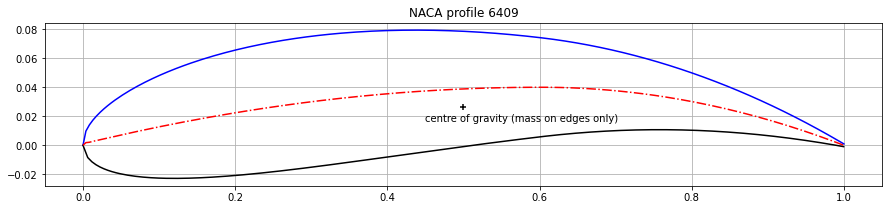

In [5]:
def plot_naca_profile(profile_name):
    foil = Airfoil.NACA4(profile_name)

    fig, ax = plt.subplots(figsize = (15 , 3))

    l = foil.all_points.shape[1]
    s = int(l/2)
    ax.set_title("NACA profile {}".format(profile_name))
    ax.plot(foil.all_points[0, : s], foil.all_points[1, :s], color = "blue")
    ax.plot(foil.all_points[0, s:], foil.all_points[1, s:], color = "black")
    ax.plot(foil.all_points[0, :s], foil.camber_line(foil.all_points[0, :s]), linestyle = "-.", color = "red")
    ax.grid()
    
    (x_g, y_g) = get_centre_of_gravity(profile_name)
    
    ax.scatter(x_g, y_g, marker = "+", color = "black")
    ax.text(x_g - 0.05, y_g - 0.01, "centre of gravity (mass on edges only)", fontsize = 10)

def get_profile_points(profile_name):
    foil = Airfoil.NACA4(profile_name)
    x = foil.all_points[0,:]
    y = foil.all_points[1,:]
    return x, y
    
def get_centre_of_gravity(profile_name):
    foil = Airfoil.NACA4(profile_name)
    
    x_g = (sum(foil.all_points[0])/len(foil.all_points[0]))
    y_g = (sum(foil.all_points[1])/len(foil.all_points[1]))
    
    return x_g, y_g

profile_name = "6409"
plot_naca_profile(profile_name)

### Profile aerodynamic performances
"XFOIL" executable is an old-fashioned but still useful tool to calculate aerodynamic performance coefficients for a 2D profile.
For this study, we will assume a Reynolds number ${Re = 10^5}$ as a constant value. In truth, the ${Re}$ changes with the increasing radial distance, being a function of the blade element chord and wind relative speed. However, since what matters in the Re definition is the magnitude, we can approximate it with a constant value used in technical literature, at least for "small" wind turbines.

#### Calling XFOIL from the notebook
The annoying fact of using "XFOIL" routine in an automatic way, is that one needs to send commands to its command window. A simple way to do this, is to write an input file, populated with string commands, and make "XFOIL" return simulation results in .txt file, which data can be imported by numpy or pandas.

Practically, to run a simulation we need to compile the input file specifying the ${Re}$, a range of angle of attack and optionally the number of iterations. The function below writes the commands in the input file (which is a new one for each simulation) and calls "XFOIL" as a subprocess, passing the before mentioned input file as an argument.
Simulation results are saved in the .txt file and then imported as pandas dataframe.

In [6]:
def run_xfoil(airfoil_name, alpha_start, alpha_end, alpha_step = 1, Re = 10**5, n_iter = 250):
    if os.path.exists("xfoil_runner/polar_file.txt"):
        os.remove("xfoil_runner/polar_file.txt")
        
    if os.path.exists("xfoil_runner/input_file.in"):
        os.remove("xfoil_runner/input_file.in")
    
    # create the input file to pass commands to xfoil
    input_file = open("xfoil_runner/input_file.in", 'w')
    input_file.write("NACA {} \n".format(airfoil_name)) # load NACA XXYY type
    input_file.write("OPER\n")
    input_file.write("Visc {}\n".format(Re))
    input_file.write("PACC\n")
    input_file.write("xfoil_runner/polar_file.txt\n") # save output to specified text file, in the working subfolder
    input_file.write("\n") # avoid saving dump file, only polar
    input_file.write("ITER {}\n".format(n_iter))
    input_file.write("ASeq {} {} {}\n".format(alpha_start, alpha_end, alpha_step))
    input_file.write("\n\n")
    input_file.write("QUIT\n")
    input_file.close()
    
    print("Executing xfoil ...")
    # call xfoil with command line, given the input file with the commands
    # output is already defined as polar text file, so no need of specifying stdout
    subprocess.run(["xfoil_runner/xfoil.exe"], stdin = open("xfoil_runner/input_file.in", "r"))   
    print("Calculation ended.")

    # load the polar data and transfor the matrix into a dataframe with given column names
    polar_data = np.loadtxt("xfoil_runner/polar_file.txt", skiprows=12)
    polar_df = pd.DataFrame(data = polar_data, 
                            columns = ["alpha", "C_l", "C_d", "C_dp", "C_m", "Top_Xtr", "Bot_Xtr"])
    
    # insert glide ratio
    polar_df.insert(loc = polar_df.columns.to_list().index("C_d") + 1, column = "C_l/C_d", value = polar_df["C_l"]/polar_df["C_d"])
    return polar_df

In [7]:
airfoil_data = run_xfoil(profile_name, 0, 15, 0.5)

Executing xfoil ...
Calculation ended.


#### Visualizing the profile aerodynamic coefficients
Given the polar dataframe, we can plot the lift and drag coefficients (${C_L}$ and ${C_D}$) and evaluate a the trend of the glide ratio $\frac {C_L}{C_D}$ as a function of the provided array of angles of attack.

In [8]:
def plot_airfoil_performance(airfoil_data, airfoil_name):
    fig, axes = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = (12, 5))
    plt.suptitle("{} airfoil - performance coefficients".format(airfoil_name))
    axes[0].plot(airfoil_data["alpha"], airfoil_data["C_l"], linestyle = "-.", marker = "^", color = "blue")
    axes[0].plot(airfoil_data["alpha"], airfoil_data["C_d"], linestyle = "--", marker = "v", color = "orange")
    axes[0].legend(["C_l", "C_d"])
    axes[0].grid(which = "major")
    
    axes[1].plot(airfoil_data["alpha"], airfoil_data["C_l"]/airfoil_data["C_d"], linestyle = "-", marker = "d", color = "red")
    axes[1].legend(["glide ratio (C_l/C_d)"])
    axes[1].set_xlabel("attack angle alpha (deg)")
    axes[1].grid(which = "major")
    plt.tight_layout()
    

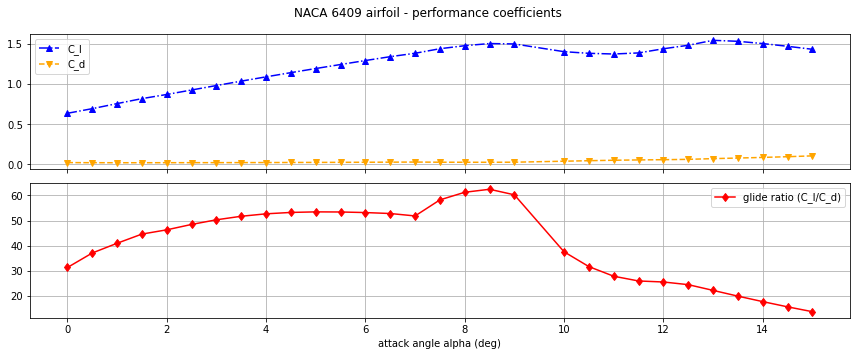

In [9]:
plot_airfoil_performance(airfoil_data, "NACA {}".format(profile_name))

### Choice of convenient angle of attack
The angle of attack will be the same for all blade lements, regardless from the radial position (i.e. if they are close to the hub or near the blade tip). The pitch angle will be a function of the blade radius.
Indeed, the plane torsion angle ${\phi}$ is the sum of the pitch angle ${\beta}$ and the attack angle ${\alpha}$, for each blade element.

${\phi} = {\alpha + \beta}$ where ${\alpha}$ is constant and decided a priori, while ${\beta}$ changes with ${r}$.

The glide ratio $\frac {C_L}{C_D}$ graph should be used to choose a custom ${\alpha}$, because we would like to maximize the lift, while minimizing the drag. A good choice of  ${\alpha}$ should satisfy following criteria:
- high $\frac {C_L}{C_D}$ but not too close from the value after that the glide ratio decays dramatically due to the rapid increase of the drag
- "stable" $\frac {C_L}{C_D}$ with small variation of ${\alpha}$ (i.e. possibly  such that the $\frac {C_L}{C_D}$ curve is "flat" around the chosen ${\alpha}$).

In [10]:
alpha = 5 #deg
C_l = airfoil_data.loc[airfoil_data["alpha"] == alpha, "C_l"].values[0] # profile lift coefficient
C_d = airfoil_data.loc[airfoil_data["alpha"] == alpha, "C_d"].values[0] # profile drag coefficient
print("alpha = {} -> C_l = {}, C_d = {}".format(alpha, C_l, C_d))

alpha = 5 -> C_l = 1.1941, C_d = 0.02234


## Blade solution with blade element momentum equations
Wind turbine blades can be designed applying BEM equations, solved with a numerical procedure. BEM equations describe how axial force and torque are generated by the turbine-air flow interaction. 

### Blade discretization
The whole blade is divided in a discrete number of blade lements in the radial direction. Each blade element is indicated by a radial distance ${r}$ and has approximate constant chord length ${c}$ and blade width ${b}$.

The blade has overall radius ${R}$ and the hub has radius ${R_H}$, so if we choose n discrete elements, all of them have the same width ${b} = \frac{R - R_H}{n}$. The radial coordinate r identifies the "centre" of the blade element, so it spans from ${R_H} + \frac{b}{2}$ until ${R} - \frac{b}{2}$.

BEM equations are derived from both the blade element theory and the conservation of angular momentum in the isolated system, composed by the rotor and the fluid flow.

### Blade element theory
According to the blade element theory, the interaction between the air flow and the blade element produces only 2 forces, lift and drag. Lift is per definition perpendicular to the wind relative velocity.
Since the blade element is rotated of an angle ${\phi}$, lift and drag can be decomposed in a tangential force (the "useful" force providing torque to the turbine) and an axial force, pushing against the rotor. 
In terms of dimensionless coefficients, one can express the tangential force coefficient and the axial force coefficient as function of the lift and drag coefficients (that are constants, being constant the angle of attack!) and the  ${\phi}$ angle, depending from the radial position of the blad element.

$ {C_T} = C_L sin(\phi) - C_D cos(\phi) $

$ {C_X} = C_L cos(\phi) + C_D sin(\phi) $

Note that the drag provides a negative contribution to the torque generation, while increasing the axial thrust.

The tangential and axial forces on the blade element can be written as follows:

$ {dF_T} = \frac {1}{2} \rho W^2 C_T c dr$ 

$ {dF_X} = \frac {1}{2} \rho W^2 C_X c dr$

and the torque produced by a single blade element becomes $ {dT}={dF_T r}= \frac {1}{2} \rho w^2 C_T c r dr$ 

### Momentum conservation
Momentum theory considers the momentum balance on the rotating anular stream passing through the wind turbine.
Fluid flow momentum can be computed considering the axial and tangential components. The variation of axial momentum is responsible of the axial force against the turbine, while the variation of angular momentum generates the torque, moving the turbine blades in the opposite direction of the fluid wake rotation.
Momentum theory introduces 2 coefficients:
- the axial induction factor ${a}$, so that the air velocity in the axial direction at the blade element leading edge can be written as $ v = {(1-a)v_1}$, where ${v_1}$ is the upstream, free wind velocity.
- the tangential induction factor ${a'}$, so that the blade element rotational velocity can be expressed as ${\omega r (1 + a')}$, where ${\omega} [rad/s]$ is the turbine anguular speed and ${r}$ is the radial coordinate of the blade element.

Considering the fluid axial velocities changes before and after the turbine, one obtains the following expression for the total axial force pushing against the turbine anular sector:

${dF_X}=\frac{1}{2}\rho{v_1}^2 {4a(1-a)} 2{\pi} r dr$

On the other hand, the overall torque produced by the same turbine anular sector is obtained considering the rotation of the air wake while crossing the turbine section and approximating the wake rotation angular speed to be ${2a'\omega}$. 

${dT}=4a'(1 - a) \rho v_1 \pi \omega r^3 dr$

### BEM equations
By equating the expressions for ${dF_X}$ and ${dT}$ obtained from blade element theory and momentum balance and considering that the blade element speed ${\omega r} = \frac{W cos(\phi)}{1+a'}$, after some simplifications and algebraic manipulations, one obtains the 3 BEM equations for ${B}$ blades: 

$ {\phi} = arctg(\frac{v_1}{\omega r} \frac{1-a}{1 + a'})$ {angle between w and $ {v_1} $}

$ \frac{a'}{1 + a'} = \frac{B c (C_L sin(\phi) - C_D cos(\phi))}{8 \pi r sin^2(\phi)}$  {eq. for the tangential induction factor}

$ \frac{a}{1 - a} = \frac{B c (C_L cos(\phi) + C_D sin(\phi))}{8 \pi r sin(\phi) cos(\phi)}$  {eq. for the axial induction factor}

### Formulation of the optimization problem
BEM equations provide a set of 3 equations in 4 incognitas, which are:
- the torsion angle ${\phi}$
- the chord length c
- the axial induction factor a
- the tangential induction factor a'

while following quantities are known for each blade element: 
- blade element radial coordinate ${r}$
- profile lift and drag coefficients ${C_L}$ and ${C_D}$ (constants because ${\alpha}$ is set a priori and ${Re}$ does not change its magnitude with ${r}$)
- the wind upstream velocity ${v_1}$
- the turbine angular velocity ${\omega}$

The number of blades ${B = 3}$ is fixed for the turbine of this study.

The problem can be re-formulated as an optimization problem, introducing an objection to be maximized and considering the 3 BEM equations as nonlinear constraints.

*Maximize*

$ {F_T} = \frac {1}{2} \rho W^2 C_T b c $ 

*subject to*

$ {\phi} = arctg(\frac{v_1}{\omega r} \frac{1-a}{1 + a'})$ 

$ \frac{a'}{1 + a'} = \frac{B c (C_L sin(\phi) - C_D cos(\phi))}{8 \pi r sin^2(\phi)}$  

$ \frac{a}{1 - a} = \frac{B c (C_L cos(\phi) + C_D sin(\phi))}{8 \pi r sin(\phi) cos(\phi)}$  

*with bounded variables*

$ \phi_{MIN} \leq \phi \leq \phi_{MAX} $ {e.g. $ \phi_{MIN} = \alpha $ }

$ c_{MIN} \leq c $

$ {0 < a < 1} $

$ {0 < a' < 1} $

*Design variables* ${a}, {a'}, {\phi}, {c}$

This practically means that we're looking for the set of design variables that maximize the tangential force on the blade element (thus the torque and the mechanical power as a direct consequence), while satisfying the blade element momentum equations.

Note the lower boundaries on ${\phi}$ and ${c}$: ${\phi}$ should always be greater than the attack angle ${\alpha}$ , in order to ensure a positive pitch angle also at the blade tip, while a minimum size for the chord can be prescribed, to avoid the blade tip to be too thin.


### Useful functions
Some utilities functions are listed here below: they are called multiple times by the solver function and allows to split the calculations in a more readable way.
The wind relative speed is computed given the leading edge velocity triangle:

${W}^2 ={v_1}^2 (1-a)^2 + (\omega r)^2 $

The second function is simply a manipulation of the 1st BEM equation, but converting the result from radians to degrees.
The remaining functions compute the tangential and axial coefficients and forces, as function of the lift and drag coefficients and other parameters.

In [11]:
def relative_speed(v_1, omega, a, r):
    w_square = ((v_1**2) * (1 - a)**2 + (omega * r)**2)
    w = sqrt(w_square)
    return w

def torsion_plane_angle(omega, r, a, a_first, v_1):
    phi = degrees(atan((1 - a) * v_1 / ((1 + a_first) * omega * r)))
    return phi

def tang_coeff(C_l, C_d, phi):
    C_t = C_l * sin(radians(phi)) - C_d * cos(radians(phi))
    return C_t

def axial_coeff(C_l, C_d, phi):
    C_x = C_l * cos(radians(phi)) + C_d * sin(radians(phi))
    return C_x

def axial_force(rho, phi, a, v_1, omega, r, C_l, C_d, b, c):
    w_square = relative_speed(v_1, omega, a, r)**2
    F_x = 0.5 * rho * w_square * axial_coeff(C_l, C_d, phi) * c * b
    return F_x

def tang_force(rho, phi, a, v_1, omega, r, C_l, C_d, b, c):
    w_square = relative_speed(v_1, omega, a, r)**2
    F_t = 0.5 * rho * w_square * tang_coeff(C_l, C_d, phi) * c *b
    return F_t

### Objective function: maximize the tangential force

In [12]:
def objective_function(x, *args):
    C_l, C_d, rho, v_1, omega, r, b = args
        
    phi = x[0]
    a = x[1]
    a_first = x[2]
    c = x[3]
    
    F_t = tang_force(rho, phi, a, v_1, omega, r, C_l, C_d, b, c)
    # -1 to maximize the tangential force (-> the same as maximizing the torque of the blade element)
    return - F_t

### BEM equations considered as equality constraints

In [13]:
def constraints_function(x, *args):
    C_l, C_d, R, omega, r, v_1, B = args
        
    phi = x[0]
    a = x[1]
    a_first = x[2]
    c = x[3]
       
    # eq. plain torsion angle -> defines the velocity triangle 
    con_0 = phi - torsion_plane_angle(omega, r, a, a_first, v_1) # phi and right term in degrees
    
    # eq. expressing the axial force as function of a (the axial induction factor)
    con_1 = (a/(1 - a)) - B*c*(axial_coeff(C_l, C_d, phi))/(8*pi*r*(sin(radians(phi)))**2)
    
    # eq. expressing the torque as function of a' (the tangential inuction factor)
    con_2 = (a_first/(1 + a_first)) - B*c*tang_coeff(C_l, C_d, phi)/(8*pi*r*sin(radians(phi))*cos(radians(phi)))
    
    # concatenate the constraining egautions into a vector
    return [con_0, con_1, con_2]

#### Example of solution for a given blade element

In [14]:
R = 1
R_h = 0.10
r_i = 0.5
n = 100
b = (R - R_h)/n
eq_cons = {"type" : "eq",
          "fun" : constraints_function,
          "args" : (C_l, C_d, R, omega, r_i, v_1, 3)}

results = minimize(fun = objective_function, x0 = [6, 1/3, 0.1, b], 
             args = (C_l, C_d, rho, v_1, omega, r_i, b), method = "SLSQP", constraints = eq_cons,
                          bounds = Bounds(lb = [1, 0, 0, 0], 
                                          ub = [89, 1, 1, np.inf]),
                    )
results

     fun: -0.0017966904319657564
     jac: array([-0.00072649,  0.00017429,  0.        , -0.0122062 ])
 message: 'Optimization terminated successfully'
    nfev: 31
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([3.54297665, 0.91650377, 0.03021662, 0.14715704])

In [15]:
-1*objective_function(results.x, C_l, C_d, rho, v_1, omega, r_i, b)    

0.0017966904319657564

In [16]:
constraints_function(results.x, C_l, C_d, R, omega, r_i, v_1, 3)

[5.280764270310101e-09, 2.7527947921157647e-08, -3.924616187589436e-11]

## Solver function 
The function below calulates the whole blade, iterating the solution of the optimization problem for each blade element.
Equality constraints and first guess for scipy's "minimize" function are dependent from the blade element parameters.
At the end, a pandas dataframe is returned as output, conaining the incognitae at each radial index.

In [17]:
def solve_blade(objective_function, constraints_function, C_l, C_d, rho, v_1, omega, r, b, R, B =3, min_phi = 0, min_c = 0.05):
        
    blade_solution = {}
    
    # design the whole blade, solving the optimization problem for each blade element
    for r_i in r:
        i = list(r).index(r_i)
        blade_solution[i] = {}
        blade_solution[i]["r_i"] = r_i
        
        # define the dictionary of the constraints to be applied @ each blade element
        eq_cons = {"type" : "eq", # equality constraint
                  "fun" : constraints_function,
                  "args" : (C_l, C_d, R, omega, r_i, v_1, B)} # <- parameters to be passed to the equality constraint function
        
        result = minimize(fun = objective_function, 
                          x0 = [10, 0, 0, min_c], 
                          args = (C_l, C_d, rho, v_1, omega, r_i, b), # < - parameters to be passed to the objective function
                          method = "SLSQP", 
                          constraints = eq_cons,
                          bounds = Bounds(lb = [min_phi, 0, 0, min_c], 
                                          ub = [89, 1, 1, np.inf])
                        )

        if result.success == True:
            (blade_solution[i]["phi"], blade_solution[i]["a"], blade_solution[i]["a_first"], blade_solution[i]["c"]) = result.x
            blade_solution[i]["C_t"] = tang_coeff(C_l, C_d, blade_solution[i]["phi"])
            blade_solution[i]["C_x"] = axial_coeff(C_l, C_d, blade_solution[i]["phi"])
            blade_solution[i]["F_x"] = axial_force(rho, blade_solution[i]["phi"], blade_solution[i]["a"], v_1, omega, blade_solution[i]["r_i"], C_l, C_d, b, blade_solution[i]["c"])
            blade_solution[i]["F_t"]  = tang_force(rho, blade_solution[i]["phi"], blade_solution[i]["a"], v_1, omega, blade_solution[i]["r_i"], C_l, C_d, b, blade_solution[i]["c"])
            blade_solution[i]["M_t"] = blade_solution[i]["F_t"] * blade_solution[i]["r_i"]
            blade_solution[i]["P"] =  blade_solution[i]["M_t"]*omega
        else:
            print("Solution did not converge for radius: {}\n{}".format(r_i, result.message))
            break
        del result
        
    # convert the dictionary to a dataframe to improve readability
    blade_solution_df = pd.DataFrame.from_dict(data = blade_solution, orient = "index")

    return blade_solution_df

## Blade solution
The code below calls the solver function, providing required inputs.

### Calling the solver function

In [18]:
B = 3
R = 3.00
R_h = 0.5
n = 50
b = (R - R_h) / n
r = np.linspace(R_h + b/2, R - b/2, n)

blade_solution_df = solve_blade(objective_function, constraints_function, 
                                C_l, C_d, rho, v_1, omega, r, b, R, min_phi = alpha, min_c = 0.05)
blade_solution_df

,r_i,phi,a,a_first,c,C_t,C_x,F_x,F_t,M_t,P
0,0.525,25.053313,0.295982,0.095795,0.303862,0.485417,1.091212,0.605403,0.269309,0.141387,1.850752
1,0.575,23.248971,0.300636,0.081408,0.291730,0.450818,1.105955,0.680589,0.277427,0.159520,2.088117
2,0.625,21.672834,0.304300,0.069907,0.279406,0.420228,1.117937,0.756022,0.284185,0.177616,2.324987
3,0.675,20.286902,0.307195,0.060588,0.267278,0.393066,1.127774,0.831458,0.289790,0.195608,2.560505
4,0.725,19.060703,0.309480,0.052944,0.255572,0.368842,1.135927,0.906726,0.294419,0.213454,2.794104
5,0.775,17.969345,0.311287,0.046606,0.244414,0.347139,1.142746,0.981734,0.298228,0.231126,3.025437
6,0.825,16.992484,0.312720,0.041300,0.233863,0.327607,1.148498,1.056432,0.301345,0.248610,3.254292
7,0.875,16.112420,0.313907,0.036822,0.223956,0.309928,1.153394,1.130888,0.303880,0.265895,3.480556
8,0.925,15.319341,0.314742,0.033002,0.214621,0.293933,1.157574,1.204791,0.305923,0.282979,3.704181
9,0.975,14.598206,0.315434,0.029728,0.205898,0.279341,1.161181,1.278437,0.307549,0.299860,3.925159


### Mechanical power produced by the blade
The global mechanical power produced by the blade is simply the sum of the power produced bt the blade elements. The same for the torque.

In [19]:
blade_power = round((blade_solution_df["P"]).sum())
blade_power
print("Blade power = {} W".format(blade_power))

# this could also be calculated with:
#(blade_solution_df["F_t"]*blade_solution_df["r_i"]).sum()*omega

Blade power = 341 W


In [20]:
print("Turbine power estimate (with {} blades) = {} W".format(B, round(B*blade_power)))

Turbine power estimate (with 3 blades) = 1023 W


### Blade power coefficient

The blade efficiency coefficient is the measure of wind turbine efficiency. For the purpose of this study, we can consider ${C_P}$ as the ratio of actual mechanical power produced by the blade divided by the total wind power flowing into the same blade are at specific wind speed.

$ {C_P} = B\frac{P_{BLADE}} {\frac{1}{2} \rho \pi R^2 v_1^3}$

Note that the hub radius ${R_H}$ negatively affects the ${P_{BLADE}}$ computation, even though blade elements close to the hub deliver less power than elements in the middle of the blade.

In [21]:
C_p = round((B*blade_solution_df["P"]).sum()/(0.5*rho*pi*R**2*v_1**3), 3)
print("C_p turbine = {}".format(C_p))

C_p turbine = 0.473


## Results visualization
Optimal design variables variation with the radial coordinate ${r}$ are reported in the graphs below. 

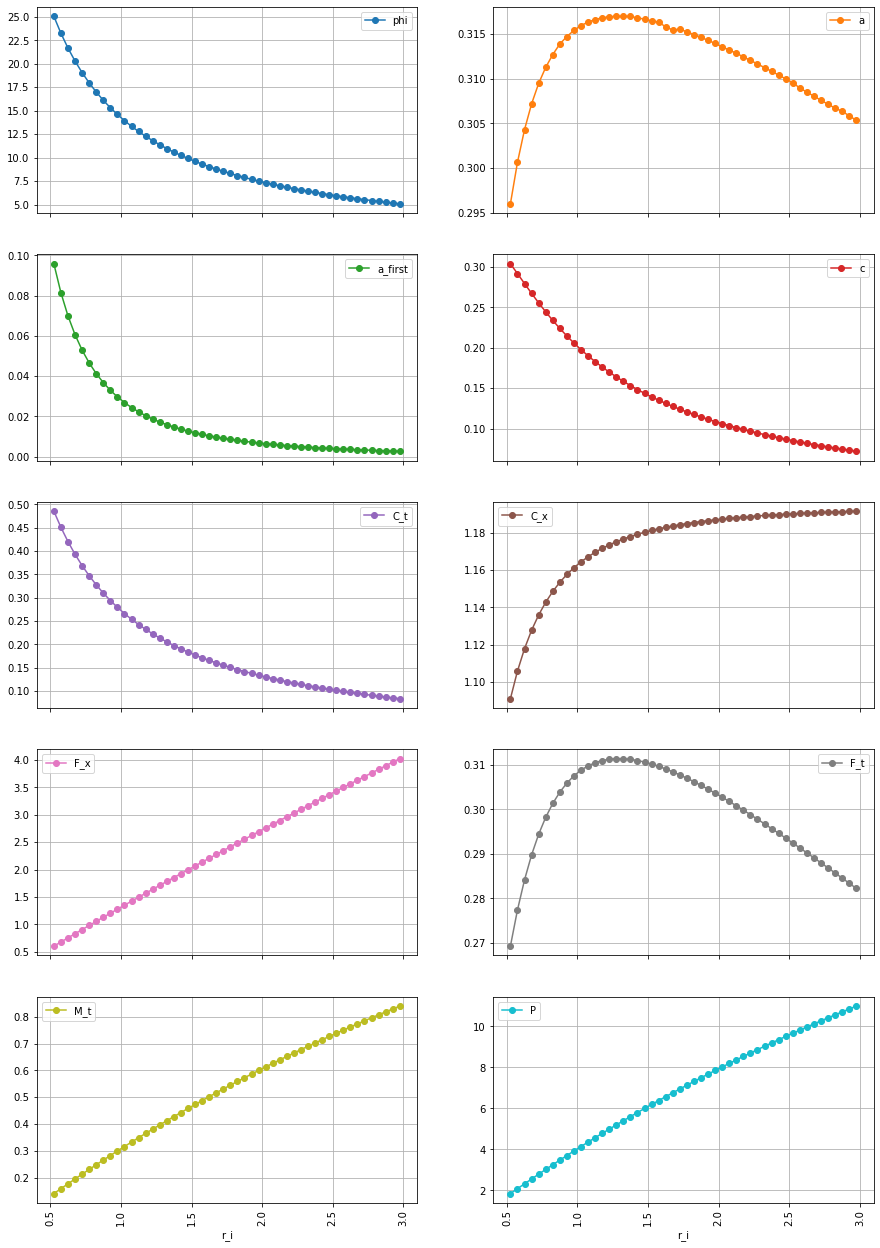

In [22]:
blade_solution_df.plot(x= 'r_i', layout=(5,2), subplots=True, sharex=True, 
                       figsize = (15, 22), grid = True, fontsize = 10, 
                       rot = 90, 
                       linestyle = "-", marker = "o");


### Constraints & objective functions visualization
It is usefult to visualize the shape of the 2 constraints functions (the ones containing the expressions for ${a}$ and ${a'}$) and the objective function, at least for 1 blade element. We can choose the ${r_i}$ index to select e.g. an element close to the hub or near the tip.

Since there are 3 constraints equations with 4 deisgn variables, for visualization purpose we can express the 2nd and the 3rd constraint as functions of the tuple (${\phi}$, ${c}$). 

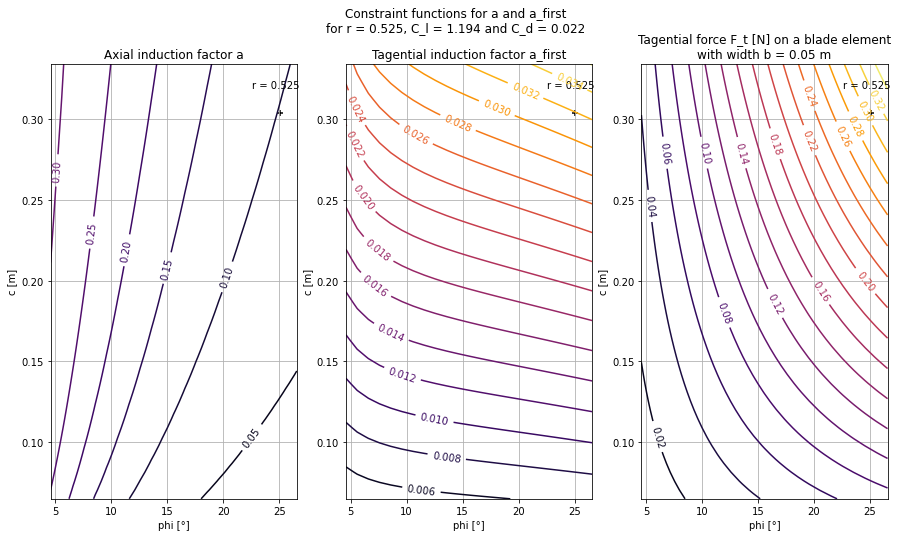

In [23]:
def plot_constraints_and_objective(r, phi_plot, c_plot, C_l, C_d, b, v_1, omega, B = 3,
                                   phi_min = 0, phi_max = 90, c_min = 0.01, c_max = 1, n = 50):
    %matplotlib inline
    def a_function(phi, c, r, C_l, C_d):
        a = c*(axial_coeff(C_l, C_d, phi))/(8 *pi*r*(sin(radians(phi)))**2 + B*c*axial_coeff(C_l, C_d, phi))
        return a

    def a_first_function(phi, c, r, C_l, C_d):
        a_first = c*tang_coeff(C_l, C_d, phi)/(8*pi*r*sin(radians(phi))*cos(radians(phi)) - B*c*tang_coeff(C_l, C_d, phi))
        return a_first
    
    phi = np.arange(phi_min, phi_max, 1)
    c = np.linspace(c_min, c_max, n)
    
    phi_grid, c_grid = np.meshgrid(phi, c)
    
    
    a = np.array([a_function(x,y, r, C_l, C_d) for x,y in zip(np.ravel(phi_grid), np.ravel(c_grid))]).reshape(phi_grid.shape)
    a_first = np.array([a_first_function(x,y, r, C_l, C_d) for x,y in zip(np.ravel(phi_grid), np.ravel(c_grid))]).reshape(phi_grid.shape)
    
    F_t = np.array([tang_force(rho, x, 
                               a_function(x, y, r, C_l, C_d), 
                               v_1, omega, r, C_l, C_d, b, y) for x,y in zip(np.ravel(phi_grid), 
                                                                      np.ravel(c_grid))]).reshape(phi_grid.shape)
    
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 8))
    plt.suptitle("Constraint functions for a and a_first\nfor r = {}, C_l = {} and C_d = {}".format(round(r, 3), round(C_l, 3), round(C_d, 3)))

    a_contour = axes[0].contour(phi_grid, c_grid, a, levels = np.arange(0, 1.1, 0.05), cmap = "inferno")
    axes[0].clabel(a_contour, inline=1, fontsize=10)
    axes[0].grid()
    axes[0].set_title("Axial induction factor a")
    axes[0].set_xlabel("phi [°]")
    axes[0].set_ylabel("c [m]")
    
    a_first_contour = axes[1].contour(phi_grid, c_grid, a_first, levels = 20, cmap = "inferno")
    axes[1].clabel(a_first_contour, inline = 1, fontsize = 10)
    axes[1].grid()
    axes[1].set_title("Tagential induction factor a_first")
    axes[1].set_xlabel("phi [°]")
    axes[1].set_ylabel("c [m]")
    
    F_t_contour = axes[2].contour(phi_grid, c_grid, F_t, levels = 20, cmap = "inferno")
    axes[2].clabel(F_t_contour, inline = 1, fontsize = 10)
    axes[2].grid()
    axes[2].set_title("Tagential force F_t [N] on a blade element\nwith width b = {} m".format(round(b, 3)))
    axes[2].set_xlabel("phi [°]")
    axes[2].set_ylabel("c [m]")
    
    for ax in axes:
        ax.scatter(phi_plot, c_plot, marker = "+", color = "black")
        ax.text(0.90*phi_plot, 1.05*c_plot, "r = {}".format(round(r,3)))

#radius_id = blade_solution_df.shape[0]-1
radius_id = 0
plot_constraints_and_objective(r = blade_solution_df.loc[radius_id, "r_i"], 
                               phi_plot = blade_solution_df.loc[radius_id, "phi"], 
                               c_plot = blade_solution_df.loc[radius_id, "c"], 
                               C_l = C_l, C_d = C_d, b = b, v_1 = v_1, 
                               omega = omega,
                                phi_min = 0.9*blade_solution_df["phi"].min(), 
                               phi_max = 1.1*blade_solution_df["phi"].max(), 
                               c_min = 0.9*blade_solution_df["c"].min(), 
                               c_max = 1.1*blade_solution_df["c"].max())


### Simplified view of the blade 

<IPython.core.display.Javascript object>


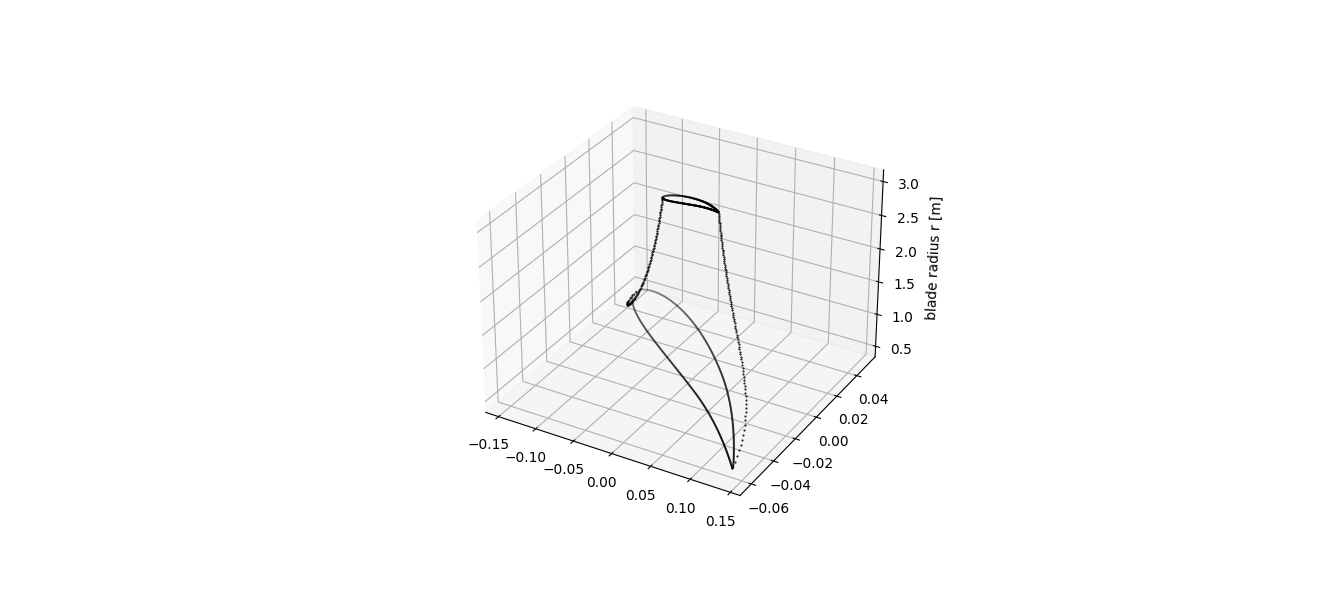

In [26]:
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_zlabel('blade radius r [m]')

for i, row in blade_solution_df.iterrows():    
    x, y = get_profile_points(profile_name)
    x_g, y_g = get_centre_of_gravity(profile_name)
    x_scaled = (x - x_g)*row["c"]
    y_scaled = (y - y_g)*row["c"]

    points = np.array([x_scaled, y_scaled])

    rot_matrix = [[cos(radians(row["phi"] - alpha)), sin(radians(row["phi"] - alpha))],
          [-sin(radians(row["phi"] - alpha)),cos(radians(row["phi"] - alpha))]]

    rotated_points = np.dot(rot_matrix, points)
    
    ax.scatter(rotated_points[0,0], rotated_points[1,0], row["r_i"], 
               marker = ".", s = 1, color = "black")
    
    ax.scatter(rotated_points[0, rotated_points.shape[1]-1], rotated_points[1,  rotated_points.shape[1]-1], 
               row["r_i"], marker = ".", s = 1, color = "black")

    if i == 0 or i == blade_solution_df.shape[0]-1:
        ax.scatter(rotated_points[0,:], rotated_points[1,:], row["r_i"], marker = ".", s = 1, color = "black")

## Convergency 
To assess the convergeny property of the method, we can repeat the calculation with the specified inpouts, but varying the number of discrete elements ${n}$. 
As can be seen from the picture below, results do not change in a significative way, once a sufficient number of elements is selected.
For the purpose of our study, choosing ${n = 50}$ is enough.

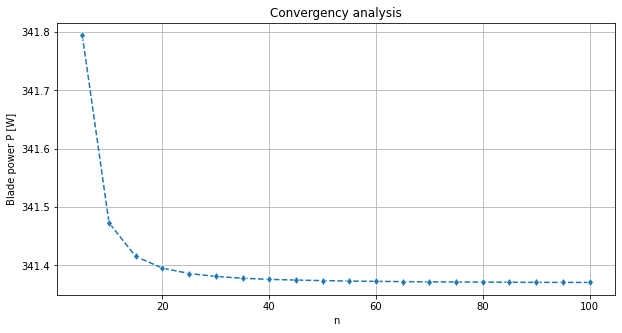

In [25]:
#R = 1
#R_h = 0.20
%matplotlib inline
overall_power = list()
n_range = np.arange(5, 105, 5)
for n in n_range:
    b = (R - R_h) / n
    r = np.linspace(R_h + b/2, R - b/2, n)

    blade_solution_df = solve_blade(objective_function, constraints_function, 
                                C_l, C_d, rho, v_1, omega, r, b, R, min_phi = 5, min_c = 0.05)
    
    overall_power.append(blade_solution_df["P"].sum())

fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(x = n_range, y = overall_power, linestyle = "--", marker = "d")
ax.set_xlabel("n")
ax.set_ylabel("Blade power P [W]")
ax.set_title("Convergency analysis")
ax.grid()

## References
### Selection of blade profiles for horizontal wind turbines
Md. Robiul Islam, Labid Bin Bashar, Dip Kumar Saha, Nazmus Sowad Rafi (2019). “Comparison and Selection of Airfoils for Small Wind Turbine between NACA and NREL’s S series Airfoil Families” International Journal of Research in Electrical, Electronics and Communication Engineering, 4(2), 1- 11.

### Integration of xfoil executable 
Many thanks for the py script by José Alfredo Rosas Còrdova, originally written to call XFOIL executable from a simple python script. I downloaded the public available source code from his Github repo: https://github.com/JARC99/Youtube but there's a Youtube vide showing a demo at: https://www.youtube.com/watch?v=zGZin_PPLdc. I adapted his code lines to write the input file for xfoil executable. Some adjustments had to be done to adapt it to the Jupyter notebook execution.

### Blade element momentum theory
Grant Ingram, Wind Turbine Blade Analysis using the Blade Element Momentum Method. Version 1.0. http://educypedia.karadimov.info/library/wind_turbine_design.pdf

Søren Gundtoft, Wind Turbines, 3rd Edition, Jan 2012.

Faisal Mahmuddin, Rotor Blade Performance Analysis with Blade Element Momentum Theory, Energy Procedia 105 (2017) 1123 – 1129